<a href="https://colab.research.google.com/github/gibaless/dl-2019/blob/master/Lab3_DL_TensorFlow_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3 - Embeddings
Students:
Jan Carbonell
Gisela Alessandrello


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Importing packages
import os
import io
from pathlib import Path
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import warnings
import random
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
from scipy import stats
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib as mpl
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.applications import VGG16, VGG19, InceptionResNetV2 
from tensorflow.keras import models, layers
from tensorflow.keras.layers import AveragePooling2D, ZeroPadding2D, Dropout, Flatten
from tensorflow.keras.layers import Input, Dense, Reshape, Activation
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import model_from_json, Sequential, Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
print(tf.__version__)

2.0.0


# New Section

In [0]:
#setting up global variables
# ATADIR = "./simpsons_dataset" #training data directory
DATADIR = '/content/drive/My Drive/MAI/DL/Lab3/simpsons_dataset'
CATEGORIES = ['bart_simpson' , 'homer_simpson', 'lisa_simpson', 'moe_szyslak', 'ned_flanders' ]

image_size=224 #image net has images trained of this size
batch_size=64
epochs=100

In [9]:
training_data = []

for category in CATEGORIES:
    print("Loading images for category: ", category, " ...")
    path = os.path.join(DATADIR, category) #path to alphabets
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        if img != '.DS_Store':
            # print(os.path.join(path,img))
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (224, 224))
            final_img = cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB)
            training_data.append([final_img, class_num])


Loading images for category:  bart_simpson  ...
Loading images for category:  homer_simpson  ...
Loading images for category:  lisa_simpson  ...
Loading images for category:  moe_szyslak  ...
Loading images for category:  ned_flanders  ...


In [0]:
# training_data[1:5]
random.shuffle(training_data)

In [11]:
X=[]
y=[]
for features,label in training_data: 
    X.append(features)
    y.append(label)
    # X = np.append(X, features)
    # y = np.append(y, label)
    
X = np.array(X).reshape(-1, image_size, image_size, 3)
X = X.astype('float32')/255.0 # to normalize data
y = to_categorical(y) #one-hot encoding
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

print("Train number of samples:", X_train.shape[0])
print("Val number of samples:", X_val.shape[0])

train_data_gen = ImageDataGenerator(
      # validation_split = 0.1, 
     horizontal_flip=True
    ) 

val_data_gen = ImageDataGenerator(
      # validation_split = 0.1, 
     horizontal_flip=True) 

train_data = train_data_gen.flow(X_train, y_train, batch_size = 32, shuffle = True)

val_data = val_data_gen.flow(X_val, y_val, batch_size = 32, shuffle = True)

Train number of samples: 5908
Val number of samples: 657


Classes: B  H  L  M  N 


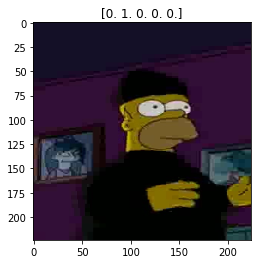

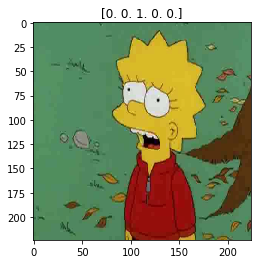

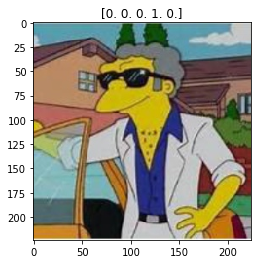

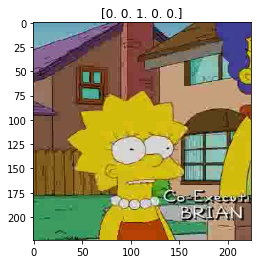

(5908, 224, 224, 3)
(657, 224, 224, 3)
(5908, 5)
(657, 5)


In [12]:
num_train_samples = X_train.shape[0]
num_val_samples = X_val.shape[1]

print(train_data)
print(val_data)

print("Classes: B  H  L  M  N ")

x,y = train_data.next()
for i in range(0,4):
    image = x[i]
    plt.imshow(image)
    plt.title(y[i])
    plt.show()


print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

In [16]:
print(y_val[1])

[0. 0. 1. 0. 0.]


In [0]:
# VGG19, InceptionResNetV2 
# conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
conv_base = VGG19(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
# conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [18]:
# Build Model 

model = Sequential()
#Add the base model
for layer in conv_base.layers:
    model.add(layer)
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [0]:
# Freeze the layers that won't be trained

for layer in model.layers[:18]:
    layer.trainable = False

#Add new custom layers
# x = model.output
# x = Flatten()(x)
# x = Dense(64, activation='relu')(x)
# x = Dense(64, activation='relu')(x)
# predictions = Dense(29, activation='softmax')(x)
# model_final = Model(inputs=model.input, output=predictions)

model.add(Flatten())
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

# model.summary()


In [20]:
# Optimizer 
# adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# sgd = SGD(lr=0.001)
# loss='mean_squared_error'
# loss='categorical_crossentropy'
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint("weights.{epoch:02d}-{val_loss:.2f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')


In [0]:
history = model.fit_generator(train_data,
                    epochs = 15,
                    # steps_per_epoch = 1,
                    validation_data=val_data,              
                    # validation_steps=3, # , we will use all val data.
                    verbose=1, 
                    # shuffle=True, 
                    # callbacks=[early, checkpoint], 
                    use_multiprocessing=True)


# The returned "history" object holds a record
# of the loss values and metric values during training
print('\nhistory dict:', history.history)

# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/MAI/DL/Lab3/model_lab3.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/MAI/DL/Lab3/model_lab3_weights.h5")
print("Saved model to disk")


Epoch 1/15
185/185 [==============================] - 265s 1s/step - loss: 0.0264 - accuracy: 0.9915 - val_loss: 0.3139 - val_accuracy: 0.9467
Epoch 2/15


In [20]:
##Model Accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


##Model Accuracy

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


NameError: ignored

Test to predict model


In [0]:

# Evaluate the model on the test data using `evaluate`


probabilities = model.predict_generator(generator=val_data)
y_true = val_data.classes
y_pred = probabilities > 0.5
from sklearn.metrics import confusion_matrix
# Plot normalized confusion matrix
mat = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(conf_mat=mat, figsize=(8, 8),
                      title='Confusion matrix (Validation)')



In [0]:

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict_generator(x_test[:3])
print('predictions shape:', predictions.shape)



print('\n# Evaluate on test data')
results = model.evaluate(x_val, y_val, batch_size=128)
print('Val loss, Val acc:', results)

DATADIR = '/content/drive/My Drive/MAI/DL/Lab3/simpsons_testset'


predictions = model.predict(x_test)
print('Predictions shape:', predictions.shape)
predictions

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')